## Assignment 4
- Working on project dataset (Image Classification using CNN TensorFlow)
- This notebook will run only on Google Colab(https://colab.research.google.com/notebooks/welcome.ipynb)
- Datasets must be uploaded on a google drive in order to access the data



In [0]:
# Installing and authenticating google drive
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1Ib82znOK1oo1i7CxH7H-POrLX2PmvAMB' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: test_batch, id: 1MxsYu6tR3CfV-fEECPeq99weyFjPRXvZ
downloading to /root/data/test_batch
title: data_batch_5, id: 1ZRcoKf2B1MsudllHbDKmuL1dMPKHVzWA
downloading to /root/data/data_batch_5
title: data_batch_4, id: 1y8-ag_FgBgG0gF8nMGbGNMbexTHjx87Q
downloading to /root/data/data_batch_4
title: data_batch_3, id: 19OQ7qW5NDeTgFkmAcSODQqO_1H4D8q9H
downloading to /root/data/data_batch_3
title: data_batch_2, id: 1bZWyvbhjJQaiogS6duUVa3BogzQ8uLpv
downloading to /root/data/data_batch_2
title: data_batch_1, id: 1RyPgX76WWA9s5lp_mgvkutu1YX6nxVgK
downloading to /root/data/data_batch_1
title: readme.html, id: 1T-hi6jdKznTPg57kBAjt-kAMfXIOiWAT
downloading to /root/data/readme.html
title: batches.meta, id: 1NWysd8WYjKlKSyDo1NbN79slyNZJOS_9
downloading to /root/data/batches.meta


In [0]:
# Define a function to unpickle the CIFAR dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [0]:
CIFAR_DIR = '/root/data/'
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
all_data = [0,1,2,3,4,5,6]
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [0]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [0]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [0]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [0]:
def one_hot_encode(vec, vals=10):
    '''
    encoding the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
# Creating helper functions
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)


        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [0]:
# Initialize the images to setup the training and test images and labels
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [0]:
# Creating Placeholders for input Images, True lables and hold probability
import tensorflow as tf
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])
hold_prob = tf.placeholder(tf.float32)

In [0]:
# Creating tensorflow variable for weights
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

# Creating tensorflow variable for biases
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

# Creating a function to compute the 2-D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Defining max pooling 
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

# Creating convolution layer with relu, selus and leaky_relu as an activation function
def convolutional_layer(input_x, shape, acti_func):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    if acti_func == 'relu':
      return tf.nn.relu(conv2d(input_x, W) + b)
    if acti_func == 'selu':
      return tf.nn.selu(conv2d(input_x, W) + b)
    if acti_func == 'leaky relu':
      return tf.nn.leaky_relu((conv2d(input_x, W) + b),alpha=0.2)

# Creating a function for fully connected network
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1015, 0.6056, 0.651, 0.676, 0.6722]


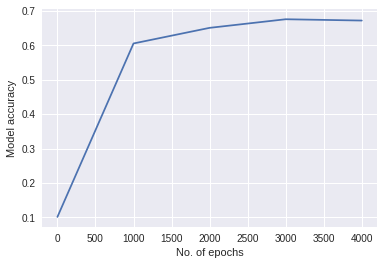

In [0]:
convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = 'relu')
convo_1_pooling = max_pool_2by2(convo_1)
convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = 'relu')
convo_2_pooling = max_pool_2by2(convo_2)
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,10)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Creating a session to run all the function in sequence
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer()) # Initializing global variables to activate all the variables
  epochs =[]
  accuracy =[]
  #for epochs in range(epochs)
  for i in range(5000):
      batch = ch.next_batch(100)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%1000 == 0:

          print('Currently on step {}'.format(i))
          #print('Accuracy is:')
          # Test the Train Model
          matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

          acc = tf.reduce_mean(tf.cast(matches,tf.float32))
          test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
          epochs.append(i)
          accuracy.append(test_acc)
          #print(test_acc)
          
          #print('\n')
  print("epochs: ",epochs)
  print("accuracy: ",accuracy)
  plt.plot(epochs,accuracy )
  plt.xlabel("No. of epochs")
  plt.ylabel("Model accuracy")
  plt.show()
  
  # save checkpoint of the model
  #checkpoint_name = os.path.join("model_checkpoint", 'model_epoch' + str(epoch + 1) + '.ckpt')
  #saver.save(sess, './my_first_model.ckpt')



### Part B: Activation Functions
- Creating a custom function similar to grid search to tune the model
- Checked the accuracy of the model for Relu, Selu and Leaky Relu activation function
- Number of Epochs is 4000

for activation funtion:  relu
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1, 0.5855, 0.6501, 0.6668, 0.6747]


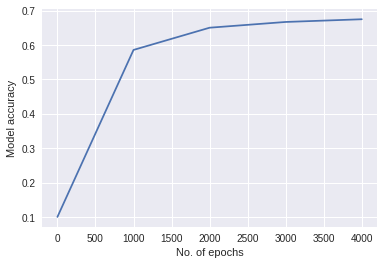

for activation funtion:  selu
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.0998, 0.5619, 0.6164, 0.6571, 0.666]


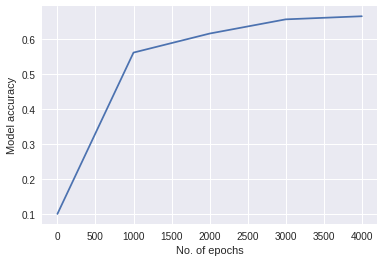

for activation funtion:  leaky relu
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1001, 0.6421, 0.6913, 0.6936, 0.7004]


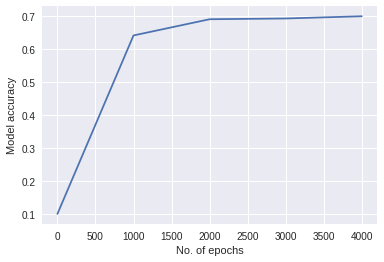

In [0]:
activation_functions =['relu','selu','leaky relu']
for act_f in activation_functions:
  print('for activation funtion: ', act_f)
  convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = act_f)
  convo_1_pooling = max_pool_2by2(convo_1)
  convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = act_f)
  convo_2_pooling = max_pool_2by2(convo_2)
  convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
  full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
  full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
  y_pred = normal_full_layer(full_one_dropout,10)
  cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train = optimizer.minimize(cross_entropy)
  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epochs =[]
    accuracy =[]
    #for epochs in range(epochs)
    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%1000 == 0:

            print('Currently on step {}'.format(i))
            #print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
            epochs.append(i)
            accuracy.append(test_acc)
            #print(test_acc)

            #print('\n')
    print("epochs: ",epochs)
    print("accuracy: ",accuracy)
    plt.plot(epochs,accuracy )
    plt.xlabel("No. of epochs")
    plt.ylabel("Model accuracy")
    plt.show()

### Results:
-----------------------------------------------------------------------------------------------------
- After trying different activation function we can say that the **Leaky Relu**  activation function works best with Image Classification data
-----------------------------------------------------------------------------------------------------
| Activation Function        | Epoches           | Accuracy  |
| ------------- |:-------------:| -----:|
| Relu     | 4000 |67.47% |
| Selu     | 4000      |   66.6% |
| Leaky Relu | 4000    |    70.04% |

**The accuracy for Relu and Leaky Relu activation function is not chaging much after 2000 Epochs which means that with these activation function the network plateaus after 2000 epochs**

### Part C: Cost Functions
- Calculating the accuracy for different cost functions
- We have used Softmax and Sigmoid activation function to test the accuracy
- Softmax convert the output in terms of probabilties where as the sigmoid function converts the results into range (0,1)

for cost funtion:  softmax
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1074, 0.5295, 0.6235, 0.6559, 0.6659]


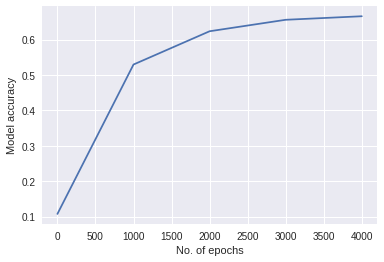

for cost funtion:  sigmoid
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1396, 0.5705, 0.6415, 0.6592, 0.6756]


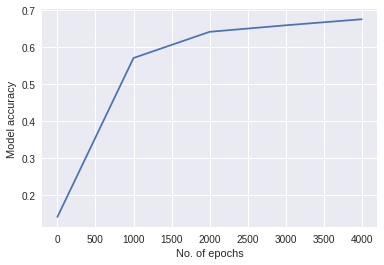

In [0]:
cost_functions =['softmax', 'sigmoid']
for cost_f in cost_functions:
  print('for cost funtion: ', cost_f)
  convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = 'selu')
  convo_1_pooling = max_pool_2by2(convo_1)
  convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = 'selu')
  convo_2_pooling = max_pool_2by2(convo_2)
  convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
  full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
  full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
  y_pred = normal_full_layer(full_one_dropout,10)
  if (cost_f == 'softmax'):
    cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))
  if (cost_f == 'sigmoid'):
    cost_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train = optimizer.minimize(cost_function)
  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epochs =[]
    accuracy =[]
    #for epochs in range(epochs)
    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%1000 == 0:

            print('Currently on step {}'.format(i))
            #print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
            epochs.append(i)
            accuracy.append(test_acc)
            #print(test_acc)

            #print('\n')
    print("epochs: ",epochs)
    print("accuracy: ",accuracy)
    plt.plot(epochs,accuracy )
    plt.xlabel("No. of epochs")
    plt.ylabel("Model accuracy")
    plt.show()

### Results:
-----------------------------------------------------------------------------------------------------
- After trying different cost function we can say that the **Sigmoid**  cost function works best withthis Image dataset
-----------------------------------------------------------------------------------------------------
| Cost Function        | Epoches           | Accuracy  |
| ------------- |:-------------:| -----:|
| Softmax     | 4000 |66.5% |
| Sigmoid     | 4000      |   67.5% |



### PART D: Epochs
- we have tried 7000 epochs and printed the accuracy for every 1000 epochs

Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
Currently on step 5000
Currently on step 6000
Currently on step 7000
epochs:  [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
accuracy:  [0.1003, 0.616, 0.6654, 0.6923, 0.7016, 0.7041, 0.7147, 0.7099]


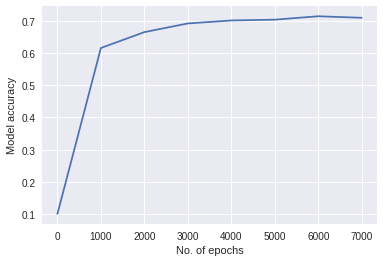

In [0]:
convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = 'relu')
convo_1_pooling = max_pool_2by2(convo_1)
convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = 'relu')
convo_2_pooling = max_pool_2by2(convo_2)
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,10)
cost_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cost_function) 
init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  epochs =[]
  accuracy =[]
  #for epochs in range(epochs)
  for i in range(8000):
      batch = ch.next_batch(100)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%1000 == 0:

          print('Currently on step {}'.format(i))
          #print('Accuracy is:')
          # Test the Train Model
          matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

          acc = tf.reduce_mean(tf.cast(matches,tf.float32))
          test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
          epochs.append(i)
          accuracy.append(test_acc)
          #print(test_acc)

          #print('\n')
  print("epochs: ",epochs)
  print("accuracy: ",accuracy)
  plt.plot(epochs,accuracy )
  plt.xlabel("No. of epochs")
  plt.ylabel("Model accuracy")
  plt.show()

### PART E: Gardient Estimation 
- Calculated the accuracy of the network for different values of Gradient Estimation
- We have tried the model with Adam, Adagrad and Adadelta gradient estimation function
- Number of Epochs are 5000

for optimizer:  adam
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.0913, 0.5888, 0.6775, 0.703, 0.7137]


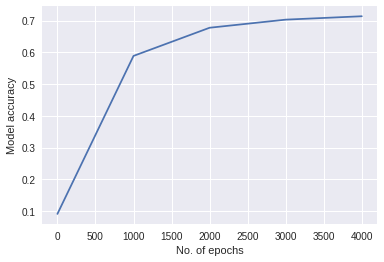

for optimizer:  adagrad
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1025, 0.2228, 0.2645, 0.2935, 0.3135]


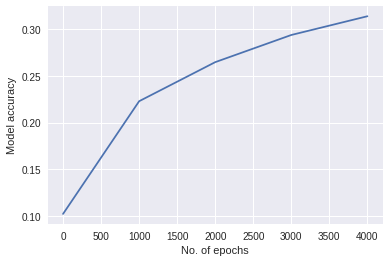

for optimizer:  adadelta
Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.0971, 0.0916, 0.1302, 0.1534, 0.1786]


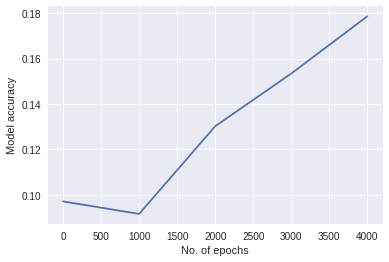

In [0]:
optimizers =['adam', 'adagrad','adadelta']
for opt in optimizers:
  print('for optimizer: ', opt)
  convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = 'leaky relu')
  convo_1_pooling = max_pool_2by2(convo_1)
  convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = 'leaky relu')
  convo_2_pooling = max_pool_2by2(convo_2)
  convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
  full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
  full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
  y_pred = normal_full_layer(full_one_dropout,10)
  cost_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred))
  if(opt == 'adam'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  if(opt == 'adagrad'):
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.001)
  if(opt == 'adadelta'):
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.001)
  train = optimizer.minimize(cost_function)
  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epochs =[]
    accuracy =[]
    #for epochs in range(epochs)
    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%1000 == 0:

            print('Currently on step {}'.format(i))
            #print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
            epochs.append(i)
            accuracy.append(test_acc)
            #print(test_acc)

            #print('\n')
    print("epochs: ",epochs)
    print("accuracy: ",accuracy)
    plt.plot(epochs,accuracy )
    plt.xlabel("No. of epochs")
    plt.ylabel("Model accuracy")
    plt.show()

### Results:
-----------------------------------------------------------------------------------------------------
- After trying different Gradient estimation function we can say that the **Adam**  gradient estimation function works best with this Image dataset
-----------------------------------------------------------------------------------------------------
| Gradient Estimation        | Epochs           | Accuracy  |
| ------------- |:-------------:| -----:|
| Adam     | 7000 |71.37% |
| Adagrad     | 7000      |   31.35% |
| Adadelta     | 7000      |   17.86% |



### PART F: Network Architecture
- Added additional filters and convolution layer to change the architecture of the Network.
- Added a batch normalization layer to normalize the weights.
- Added more fully connected layers to increase the network size and Number of neurons

Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1, 0.6381, 0.7025, 0.7383, 0.7388]


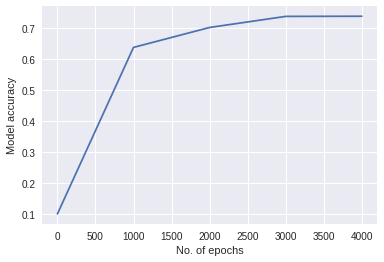

In [0]:
#convolutional filters for different layers
filter1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
filter2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
filter3 = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
filter4 = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

#convolutional layer 1
conv_layer1 = tf.nn.conv2d(x, filter1, strides=[1,1,1,1], padding='SAME')
conv_layer1 = tf.nn.relu(conv_layer1)
layer1_pool = tf.nn.max_pool(conv_layer1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
layer1_bn = tf.layers.batch_normalization(layer1_pool)

#convolutional layer 2
conv_layer2 = tf.nn.conv2d(layer1_bn, filter2, strides=[1,1,1,1], padding='SAME')
conv_layer2 = tf.nn.relu(conv_layer2)
layer2_pool = tf.nn.max_pool(conv_layer2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
layer2_bn = tf.layers.batch_normalization(layer2_pool)

#convolutional layer 3
conv_layer3 = tf.nn.conv2d(layer2_bn, filter3, strides=[1,1,1,1], padding='SAME')
conv_layer3 = tf.nn.relu(conv_layer3)
layer3_pool = tf.nn.max_pool(conv_layer3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
layer3_bn = tf.layers.batch_normalization(layer3_pool)

#flatten
flat_layer = tf.contrib.layers.flatten(layer3_bn)

#fully connected layers
#layer 1
full_layer1 = tf.contrib.layers.fully_connected(inputs=flat_layer, num_outputs=128, activation_fn=tf.nn.relu)
full_layer1 = tf.nn.dropout(full_layer1, keep_prob= hold_prob)
full_layer1 = tf.layers.batch_normalization(full_layer1)

#layer2
full_layer2 = tf.contrib.layers.fully_connected(inputs=full_layer1, num_outputs=256, activation_fn=tf.nn.relu)
full_layer2 = tf.nn.dropout(full_layer2, keep_prob= hold_prob)
full_layer2 = tf.layers.batch_normalization(full_layer2)

#layer3
full_layer3 = tf.contrib.layers.fully_connected(inputs=full_layer2, num_outputs=512, activation_fn=tf.nn.relu)
full_layer3 = tf.nn.dropout(full_layer3, keep_prob= hold_prob)
full_layer3 = tf.layers.batch_normalization(full_layer3)

#output layer
y_pred = tf.contrib.layers.fully_connected(inputs=full_layer3, num_outputs=10, activation_fn=None)

#cost function & optimizer
cost_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cost_function)
init = tf.global_variables_initializer()

#train the model over batches
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  epochs =[]
  accuracy =[]
  #for epochs in range(epochs)
  for i in range(5000):
      batch = ch.next_batch(100)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%1000 == 0:

          print('Currently on step {}'.format(i))
          #print('Accuracy is:')
          # Test the Train Model
          matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

          acc = tf.reduce_mean(tf.cast(matches,tf.float32))
          test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
          epochs.append(i)
          accuracy.append(test_acc)
          #print(test_acc)

          #print('\n')
  print("epochs: ",epochs)
  print("accuracy: ",accuracy)
  plt.plot(epochs,accuracy )
  plt.xlabel("No. of epochs")
  plt.ylabel("Model accuracy")
  plt.show()

#### Result:
-----------------------------------------------------------------------------------------------------
** Accuracy has improved significantly from 67.22% to 73.88% after  tuning the network architecture**


### PART G: Network Initialization

#### A: xavier_initializer()

In [0]:
def init_weights(shape, name):
    init_random_dist = tf.get_variable(name, shape=shape,initializer=tf.contrib.layers.xavier_initializer())
    return tf.Variable(init_random_dist)
  
def convolutional_layer(input_x, shape, acti_func, name):
    W = init_weights(shape, name)
    b = init_bias([shape[3]])
    if acti_func == 'relu':
      return tf.nn.relu(conv2d(input_x, W) + b)
    if acti_func == 'selu':
      return tf.nn.selu(conv2d(input_x, W) + b)
    if acti_func == 'leaky relu':
      return tf.nn.leaky_relu((conv2d(input_x, W) + b),alpha=0.2)

def normal_full_layer(input_layer, size, name):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size], name)
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1, 0.5707, 0.6407, 0.6678, 0.6925]


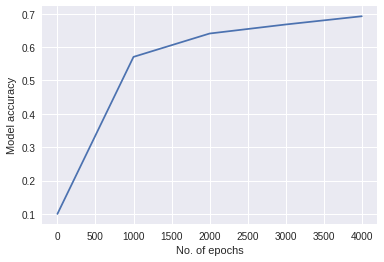

In [0]:
convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = 'relu', name = "XYZ")
convo_1_pooling = max_pool_2by2(convo_1)
convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = 'relu', name="XYZ1")
convo_2_pooling = max_pool_2by2(convo_2)
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024, name="XYZ2"))
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,10,name = "XYZ3")
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)
init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  epochs =[]
  accuracy =[]
  #for epochs in range(epochs)
  for i in range(5000):
      batch = ch.next_batch(100)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%1000 == 0:

          print('Currently on step {}'.format(i))
          #print('Accuracy is:')
          # Test the Train Model
          matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

          acc = tf.reduce_mean(tf.cast(matches,tf.float32))
          test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
          epochs.append(i)
          accuracy.append(test_acc)
          #print(test_acc)

          #print('\n')
  print("epochs: ",epochs)
  print("accuracy: ",accuracy)
  plt.plot(epochs,accuracy )
  plt.xlabel("No. of epochs")
  plt.ylabel("Model accuracy")
  plt.show()

**B: variance_scaling_initializer**

In [0]:
def init_weights(shape, name):
    init_random_dist = tf.get_variable(name, shape=shape,initializer=tf.contrib.layers.variance_scaling_initializer(
    factor=2.0,
    mode='FAN_IN',
    uniform=False,
    seed=None,
    dtype=tf.float32
))
    return tf.Variable(init_random_dist)

Currently on step 0
Currently on step 1000
Currently on step 2000
Currently on step 3000
Currently on step 4000
epochs:  [0, 1000, 2000, 3000, 4000]
accuracy:  [0.1005, 0.6124, 0.664, 0.678, 0.6951]


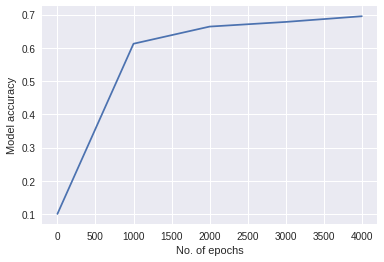

In [0]:
convo_1 = convolutional_layer(input_x = x,shape=[4,4,3,32],acti_func = 'relu', name = "Z")
convo_1_pooling = max_pool_2by2(convo_1)
convo_2 = convolutional_layer(input_x = convo_1_pooling,shape=[4,4,32,64],acti_func = 'relu', name="Z1")
convo_2_pooling = max_pool_2by2(convo_2)
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024, name="Z2"))
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,10,name = "Z3")
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)
init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  epochs =[]
  accuracy =[]
  #for epochs in range(epochs)
  for i in range(5000):
      batch = ch.next_batch(100)
      sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

      # PRINT OUT A MESSAGE EVERY 100 STEPS
      if i%1000 == 0:

          print('Currently on step {}'.format(i))
          #print('Accuracy is:')
          # Test the Train Model
          matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

          acc = tf.reduce_mean(tf.cast(matches,tf.float32))
          test_acc = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
          epochs.append(i)
          accuracy.append(test_acc)
          #print(test_acc)

          #print('\n')
  print("epochs: ",epochs)
  print("accuracy: ",accuracy)
  plt.plot(epochs,accuracy )
  plt.xlabel("No. of epochs")
  plt.ylabel("Model accuracy")
  plt.show()

### Conclusion:

#### Initial Model Accuracy - **67.22**

**Best Parameters for Image Classification Datasets are:**
- Activation Function - **Leaky Relu**
- Cost Fucntion - **Sigmoid**
- Gradient Estimation - **Adam**
- Network Initialization - **truncated_normal** to initialize the weights

#### Model Accuracy after network tuning - 73.88%


References :
1) https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive  
2)https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c  
3) https://github.com/nicoprocessor/deepTF-tutorial/tree/55977a5e30371409f88724c604acb31a781be79c  
4)https://www.tensorflow.org/api_docs/python/tf  

